### Description
- This code builds, trains, and evaluates six machine learning models.
  - CNN: Main model, base model
  - LSTM: Main model, base model
  - XGBoost: Main model, base model
- In particular, it compares two models which belong to the same category.
- Main models are trained without target station's PM2.5 data while base models are trained with target station's PM2.5 data.
- Comparison between main & base models are conducted

### Import Libraries

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import glob
import re
import matplotlib.pyplot as plt
from scipy import signal
import statsmodels.api as sm
import datetime

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.decomposition import PCA
import xgboost
from xgboost import XGBRegressor

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

### Read input files

In [7]:
# Reading files
XTrain_path = r'XTrain.csv'
XTrain_path_PM25 = r'XTrain_PM25.csv'
yTrain_path = r'yTrain.csv'
XTest_path = r'XTest.csv'
XTest_path_PM25 = r'XTest_PM25.csv'
yTest_path = r'yTest.csv'

XTrain = pd.read_csv(XTrain_path, on_bad_lines='skip')
XTrain_PM25 = pd.read_csv(XTrain_path_PM25, on_bad_lines='skip')
yTrain = pd.read_csv(yTrain_path, on_bad_lines='skip')

XTest = pd.read_csv(XTest_path, on_bad_lines='skip')
XTest_PM25 = pd.read_csv(XTest_path_PM25, on_bad_lines='skip')
yTest = pd.read_csv(yTest_path, on_bad_lines='skip')

print('Shape of XTrain: ' + str(XTrain.shape) + ' -> XTrain dataset for fitting the main models')
print('Shape of XTrain_PM25: ' + str(XTrain_PM25.shape) + " -> XTrain with target station's PM25 value for fitting the base1/base2 models")
print('Shape of yTrain: ' + str(yTrain.shape) + ' -> yTrain dataset for fitting the main/base1/base2 models')

print('Shape of XTest: ' + str(XTest.shape) + ' -> XTest dataset for testing the main models')
print('Shape of XTest_PM25: ' + str(XTest_PM25.shape) + " -> XTest with target stations's PM25 value for testing the base1/base2 models")
print('Shape of yTest: ' + str(yTest.shape) + ' -> yTest dataset for testing the moain/base1/base2 models')

Shape of XTrain: (34890, 12) -> XTrain dataset for fitting the main models
Shape of XTrain_PM25: (34890, 13) -> XTrain with target station's PM25 value for fitting the base1/base2 models
Shape of yTrain: (34723, 2) -> yTrain dataset for fitting the main/base1/base2 models
Shape of XTest: (8730, 12) -> XTest dataset for testing the main models
Shape of XTest_PM25: (8730, 13) -> XTest with target stations's PM25 value for testing the base1/base2 models
Shape of yTest: (8563, 2) -> yTest dataset for testing the moain/base1/base2 models


### Data preprocessing

In [8]:
# Clipping PM25 data
# Small subset of PM25 value is much higher than average
# Clip PM25 values to 0~100 (Over 100 is very poor according to the EPA)
columns=['Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']
columns2 = ['PM25', 'Upland_PM25', 'Lake_Elsinore_PM25', 'Temecula_PM25', 'Banning_PM25', 'Central_San_Bernardino_PM25']

XTrain[columns] = np.clip(XTrain[columns], a_min=0, a_max=100)
XTrain_PM25[columns2] = np.clip(XTrain_PM25[columns2], a_min=0, a_max=100)
XTest[columns] = np.clip(XTest[columns], a_min=0, a_max=100)
XTest_PM25[columns2] = np.clip(XTest_PM25[columns2], a_min=0, a_max=100)

yTrain['PM25'] = np.clip(yTrain['PM25'], a_min=0, a_max=100)
yTest['PM25'] = np.clip(yTest['PM25'], a_min=0, a_max=100)

In [9]:
# Standardization
# Standardize the Training data for each column
from sklearn.preprocessing import StandardScaler

ori_col = [column for column in XTrain.columns if column!='Date Time']
ori_col_PM25 = [column for column in XTrain_PM25.columns if column!='Date Time']

scaler_train = StandardScaler()
scaler_trainPM25 = StandardScaler()

scaler_train.fit(XTrain[ori_col])
XTrain_std = scaler_train.transform(XTrain[ori_col])
XTest_std = scaler_train.transform(XTest[ori_col])

scaler_trainPM25.fit(XTrain_PM25[ori_col_PM25])
XTrain_PM25_std = scaler_trainPM25.transform(XTrain_PM25[ori_col_PM25])
XTest_PM25_std = scaler_trainPM25.transform(XTest_PM25[ori_col_PM25])

In [10]:
# Preparing for time-series train/test data
# Rolling the data 
# For example, XTrain[:167] is matched with yTrain[0], XTrain[1:168] is matched with yTrain[1] and so on
window = 168

# XTrain: shape (34872, 12)
# XTrain_ts: shape (34705, 168, 11)
XTrain_ts = []

for i in range(len(yTrain)):
  start = i
  end = i + window
  XTrain_ts.append(XTrain_std[start:end, :])

XTrain_ts = np.array(XTrain_ts)
print('Shape of XTrain: ' + str(XTrain_ts.shape))


# XTrain_PM25: shape (34872, 13)
# XTrain_PM25_ts: shape (34705, 168, 12)
XTrain_PM25_ts = []

for i in range(len(yTrain)):
  start = i
  end = i + window
  XTrain_PM25_ts.append(XTrain_PM25_std[start:end, :])

XTrain_PM25_ts = np.array(XTrain_PM25_ts)
print('Shape of XTrain_PM25: ' + str(XTrain_PM25_ts.shape))


# XTest: shape (8712, 12)
# XTest_ts: shape (8545, 168, 11)
XTest_ts = []

for i in range(len(yTest)):
  start = i
  end = i + window
  XTest_ts.append(XTest_std[start:end, :])

XTest_ts = np.array(XTest_ts)
print('Shape of XTest: ' + str(XTest_ts.shape))


# XTest_PM25: shape (34872, 13)
# XTest_PM25_ts: shape (34705, 168, 12)
XTest_PM25_ts = []

for i in range(len(yTest)):
  start = i
  end = i + window
  XTest_PM25_ts.append(XTest_PM25_std[start:end, :])

XTest_PM25_ts = np.array(XTest_PM25_ts)
print('Shape of XTest_PM25: ' + str(XTest_PM25_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTrain_PM25: (34723, 168, 12)
Shape of XTest: (8563, 168, 11)
Shape of XTest_PM25: (8563, 168, 12)


### CNN model

In [11]:
# Reshaping the input data to make it fit for CNN models
# Reshaping a sample data from (168, 11) to (24, 7, 11)
# Since there is a strong relationship every 24 hours, we decided to reshape the data to (24, 7, 11)
# Input data shape: (no of samples, hours, day, no of features)

XTrain_ts = XTrain_ts.reshape((XTrain_ts.shape))
XTrain_PM25_ts = XTrain_PM25_ts.reshape((XTrain_PM25_ts.shape))
XTest_ts = XTest_ts.reshape((XTest_ts.shape))
XTest_PM25_ts = XTest_PM25_ts.reshape((XTest_PM25_ts.shape))

print('Shape of XTrain: ' + str(XTrain_ts.shape))
print('Shape of XTrain_PM25: ' + str(XTrain_PM25_ts.shape))
print('Shape of XTest: ' + str(XTest_ts.shape))
print('Shape of XTest_PM25: ' + str(XTest_PM25_ts.shape))

Shape of XTrain: (34723, 168, 11)
Shape of XTrain_PM25: (34723, 168, 12)
Shape of XTest: (8563, 168, 11)
Shape of XTest_PM25: (8563, 168, 12)


In [12]:
from tensorflow import keras

# Build a CNN model
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=12, kernel_size=24, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv1_pool = keras.layers.AveragePooling1D(pool_size=2)(conv1)

    # conv2 = keras.layers.Conv1D(filters=8, kernel_size=24, padding="same")(conv1_pool)
    # conv2 = keras.layers.BatchNormalization()(conv2)
    # conv2 = keras.layers.ReLU()(conv2)

    # conv2_pool = keras.layers.AveragePooling1D(pool_size=3)(conv2)

    # conv3 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv2_max)
    # conv3 = keras.layers.BatchNormalization()(conv3)
    # conv3 = keras.layers.ReLU()(conv3)

    # conv3_max = keras.layers.MaxPool1D(pool_size=3)(conv3)

    # conv4 = keras.layers.Conv1D(filters=4, kernel_size=24, padding="same")(conv3_max)
    # conv4 = keras.layers.BatchNormalization()(conv4)
    # conv4 = keras.layers.ReLU()(conv4)

    flatten = keras.layers.Flatten()(conv1_pool)

    dense1 = keras.layers.Dense(16)(flatten)
    dense2 = keras.layers.Dense(8)(dense1)


    output_layer = keras.layers.Dense(1)(dense2)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)

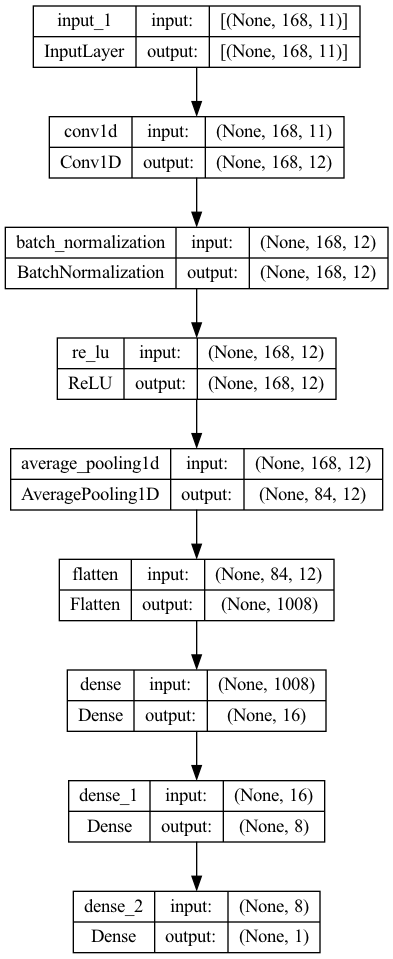

In [13]:
# Main model
# Model without PM25 data
model_main = make_model(input_shape=XTrain_ts.shape[1:])
keras.utils.plot_model(model_main, show_shapes=True)

In [14]:
epochs = 5
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_main.compile(
    optimizer="adam",
    loss="mse",
    metrics=['mae'],
    run_eagerly=True
)
history = model_main.fit(
    np.asarray(XTrain_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 15s 134ms/step - loss: 93.6616 - mae: 6.7870 - val_loss: 105.3481 - val_mae: 7.0597 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 19s 173ms/step - loss: 57.7500 - mae: 5.1602 - val_loss: 106.8422 - val_mae: 7.0660 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 19s 172ms/step - loss: 52.5891 - mae: 4.8822 - val_loss: 90.1234 - val_mae: 6.4396 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 18s 167ms/step - loss: 50.1457 - mae: 4.7724 - val_loss: 95.4838 - val_mae: 6.7188 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 14s 125ms/step - loss: 48.3802 - mae: 4.6897 - val_loss: 92.1339 - val_mae: 6.5156 - lr: 0.0010


In [15]:
# Performance metrics with the main model
y_hat = model_main.predict(XTest_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 3s 10ms/step
R2_score: 0.35547564621222905
MSE: 74.28906737612952
MAE: 5.706350039763319


Text(0, 0.5, 'Prediction')

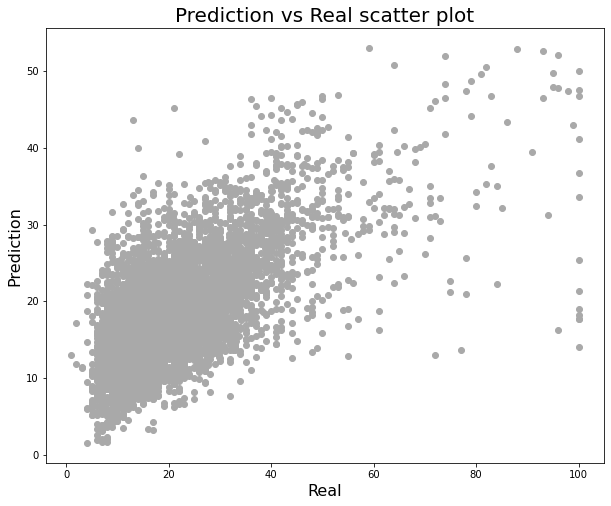

In [16]:
# Scatter Plot
plt.rcParams["figure.figsize"] = (10,8)
plt.scatter(yTest['PM25'], y_hat, c='darkgrey')
plt.title('Prediction vs Real scatter plot', fontsize=20)
plt.xlabel('Real', fontsize=16)
plt.ylabel('Prediction', fontsize=16)

<AxesSubplot:title={'center':'Average error according to PM2.5 Level'}, xlabel='Real PM2.5 Level', ylabel='Absoulte Error'>

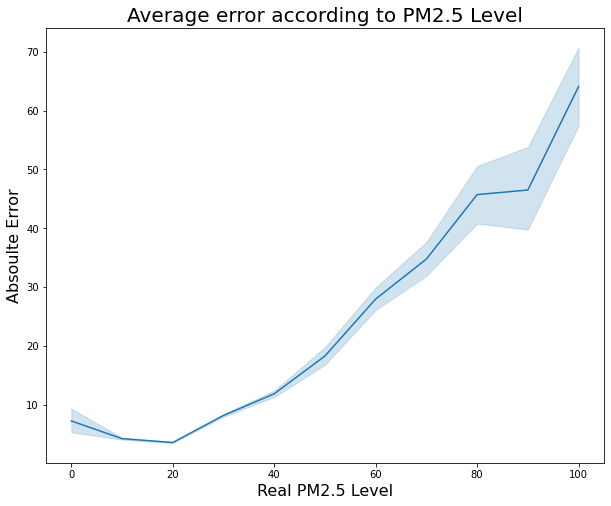

In [17]:
# Average error over PM2.5 level
df = pd.DataFrame(yTest['PM25'])
df['yhat'] = pd.DataFrame(y_hat)
df['diff'] = abs(df['PM25']-df['yhat'])
df['rnd'] = np.round(df['PM25'], -1)

df_grp = df.groupby('rnd').mean()['diff']
x = df['rnd']
y = df['diff']

plt.xlabel('Real PM2.5 Level', fontsize=16)
plt.ylabel('Absoulte Error', fontsize=16)
plt.title('Average error according to PM2.5 Level', fontsize=20)
sns.lineplot(np.array(x), np.array(y))

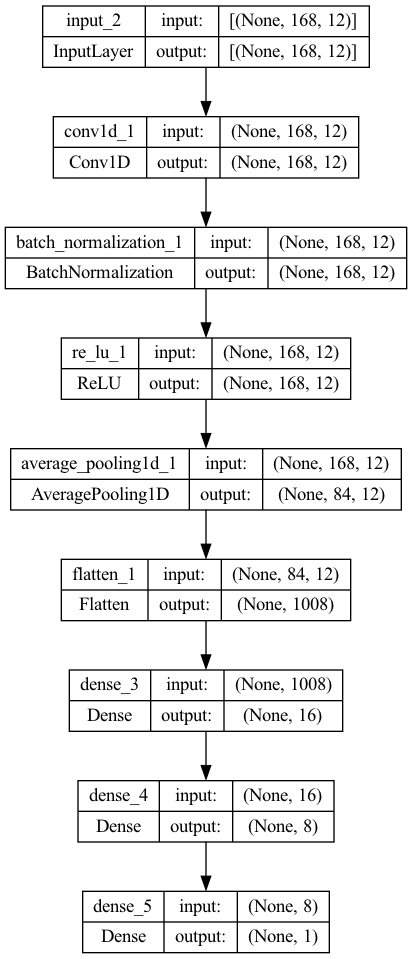

In [18]:
# Base model2
# Model with PM25 data
model_base2 = make_model(input_shape=XTrain_PM25_ts.shape[1:])
keras.utils.plot_model(model_base2, show_shapes=True)

In [19]:
epochs = 5
batch_size = 256

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model_base2.compile(
    optimizer="adam",
    loss="mse",
    metrics=['mae'],
    run_eagerly=True
)
history = model_base2.fit(
    np.asarray(XTrain_PM25_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 15s 136ms/step - loss: 94.3888 - mae: 6.7491 - val_loss: 87.8712 - val_mae: 6.6644 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 15s 141ms/step - loss: 56.5999 - mae: 5.0693 - val_loss: 88.0373 - val_mae: 6.4545 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 15s 136ms/step - loss: 50.9851 - mae: 4.7620 - val_loss: 80.8448 - val_mae: 6.1856 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 16s 146ms/step - loss: 48.2237 - mae: 4.6350 - val_loss: 74.7373 - val_mae: 5.9261 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 16s 150ms/step - loss: 46.3318 - mae: 4.5438 - val_loss: 70.8161 - val_mae: 5.7106 - lr: 0.0010


In [20]:
# Performance metrics with the base model2
y_hat = model_base2.predict(XTest_PM25_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))

268/268 [==============================] - 3s 12ms/step
R2_score: 0.450116987286163
MSE: 63.38053161283415
MAE: 5.295077858616116


In [21]:
# Defining total accuracy index
def cal_p(y_hat, y_true):
  return 1-np.sum(abs(y_hat-y_true))/np.sum(y_true)

In [22]:
# Comparing main & Base model
fin = pd.DataFrame.from_dict({'MSE': [mean_squared_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))
                                      ,mean_squared_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))],
                              'MAE': [mean_absolute_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))
                                     ,mean_absolute_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))],
                              'P': [cal_p(np.array(yTest['PM25']), model_main.predict(XTest_ts).reshape(-1))
                                    ,cal_p(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts).reshape(-1))]})

268/268 [==============================] - 3s 9ms/step


In [23]:
# set height of bar
MSE_M = [mean_squared_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))]
MSE_B = [mean_squared_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))]

MAE_M = [mean_absolute_error(np.array(yTest['PM25']), model_main.predict(XTest_ts))]
MAE_B = [mean_absolute_error(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts))]

P_M = [cal_p(np.array(yTest['PM25']), model_main.predict(XTest_ts).reshape(-1))]
P_B = [cal_p(np.array(yTest['PM25']), model_base2.predict(XTest_PM25_ts).reshape(-1))]

268/268 [==============================] - 3s 10ms/step


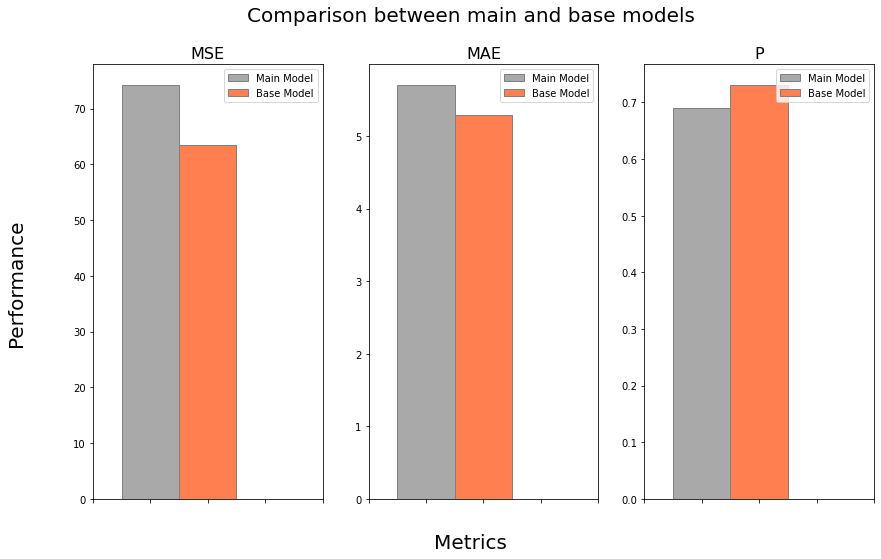

In [24]:
# Set position of bar on X axis
# creating the dataset
# set width of bar
barWidth = 0.05

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize =(14, 8))

br1 = np.arange(len(MSE_M))
br2 = [x + barWidth for x in br1]
 
# Make the plot
ax1.bar(br1, MSE_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax1.bar(br2, MSE_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax1.set_xlim(-0.05, 0.15)
ax1.set_xticklabels([])


ax2.bar(br1, MAE_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax2.bar(br2, MAE_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax2.set_xlim(-0.05, 0.15)
ax2.set_xticklabels([])

ax3.bar(br1, P_M, color ='darkgrey', width = barWidth,
        edgecolor ='grey', label ='Main Model')
ax3.bar(br2, P_B, color ='coral', width = barWidth,
        edgecolor ='grey', label ='Base Model')
ax3.set_xlim(-0.05, 0.15)
ax3.set_xticklabels([])

# Adding Xticks
fig.suptitle('Comparison between main and base models', fontsize=20)
ax1.set_title('MSE', fontsize=16)
ax1.legend()

ax2.set_title('MAE', fontsize=16)
ax2.legend()

ax3.set_title('P', fontsize=16)
ax3.legend()

fig.text(0.5, 0.04, 'Metrics', fontsize=20, ha='center')
fig.text(0.04, 0.5, 'Performance', fontsize=20 , va='center', rotation='vertical')
 
plt.show()

### LSTM model

In [27]:
# Main Model
inputs = keras.layers.Input(shape=(XTrain_ts.shape[1], XTrain_ts.shape[2]))
lstm1 = keras.layers.LSTM(64)(inputs)
dense1 = keras.layers.Dense(16)(lstm1)
dense2 = keras.layers.Dense(8)(dense1)
outputs = keras.layers.Dense(1)(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 168, 11)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                19456     
                                                                 
 dense_9 (Dense)             (None, 16)                1040      
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 20,641
Trainable params: 20,641
Non-trainable params: 0
_________________________________________________________________


In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

epochs=5
batch_size = 256

history = model.fit(
    np.asarray(XTrain_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 52s 480ms/step - loss: 72.0043 - val_loss: 96.0900 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 41s 375ms/step - loss: 59.4524 - val_loss: 87.4625 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 41s 374ms/step - loss: 54.4271 - val_loss: 86.2375 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 34s 315ms/step - loss: 51.2247 - val_loss: 87.9075 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 40s 371ms/step - loss: 48.6286 - val_loss: 100.7012 - lr: 0.0010


In [31]:
# Performance metrics with the main model
y_hat = model.predict(XTest_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))
print('P: ' + str(cal_p(np.array(yTest['PM25']), model.predict(XTest_ts).reshape(-1))))

268/268 [==============================] - 8s 30ms/step
R2_score: 0.3764487783199404
MSE: 71.8716654345556
MAE: 5.571200986726107
268/268 [==============================] - 6s 24ms/step
P: 0.6956984900761549


In [32]:
# Base model
inputs = keras.layers.Input(shape=(XTrain_PM25_ts.shape[1], XTrain_PM25_ts.shape[2]))
lstm1 = keras.layers.LSTM(64)(inputs)
dense1 = keras.layers.Dense(16, activation='relu')(lstm1)
dense2 = keras.layers.Dense(8, activation='relu')(dense1)
outputs = keras.layers.Dense(1)(dense2)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 168, 12)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                19712     
                                                                 
 dense_12 (Dense)            (None, 16)                1040      
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 1)                 9         
                                                                 
Total params: 20,897
Trainable params: 20,897
Non-trainable params: 0
_________________________________________________________________


In [33]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

epochs=5
batch_size = 256

history = model.fit(
    np.asarray(XTrain_PM25_ts).astype(np.float64),
    np.asarray(yTrain['PM25']).astype(np.float64),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/5
109/109 [==============================] - 45s 367ms/step - loss: 263.5488 - val_loss: 140.2468 - lr: 0.0010
Epoch 2/5
109/109 [==============================] - 41s 379ms/step - loss: 85.6446 - val_loss: 98.8959 - lr: 0.0010
Epoch 3/5
109/109 [==============================] - 43s 392ms/step - loss: 63.0823 - val_loss: 79.3362 - lr: 0.0010
Epoch 4/5
109/109 [==============================] - 40s 369ms/step - loss: 56.2175 - val_loss: 72.3345 - lr: 0.0010
Epoch 5/5
109/109 [==============================] - 38s 344ms/step - loss: 52.8603 - val_loss: 69.6222 - lr: 0.0010


In [34]:
# Performance metrics with the base model
y_hat = model.predict(XTest_PM25_ts)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))
print('P: ' + str(cal_p(np.array(yTest['PM25']), model.predict(XTest_PM25_ts).reshape(-1))))

268/268 [==============================] - 7s 23ms/step
R2_score: 0.4362413706815229
MSE: 64.97986080927112
MAE: 5.31088169286606
268/268 [==============================] - 7s 26ms/step
P: 0.7403104821734143


### XGBoost

In [35]:
# Reshaping input data
(s1, s2, s3) = XTrain_ts.shape
XTrain_tree = XTrain_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTrain_PM25_ts.shape
XTrain_PM25_tree = XTrain_PM25_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTest_ts.shape
XTest_tree = XTest_ts.reshape((s1, s2*s3))

(s1, s2, s3) = XTest_PM25_ts.shape
XTest_PM25_tree = XTest_PM25_ts.reshape((s1, s2*s3))

print('XTrain: ' + str(XTrain_tree.shape))
print('XTrain_PM25: ' + str(XTrain_PM25_tree.shape))
print('XTest: ' + str(XTest_tree.shape))
print('XTest_PM25: ' + str(XTest_PM25_tree.shape))

XTrain: (34723, 1848)
XTrain_PM25: (34723, 2016)
XTest: (8563, 1848)
XTest_PM25: (8563, 2016)


In [37]:
# Apply PCA to reduces the number of features
pca = PCA(n_components=150)
pca.fit(XTrain_tree)
XTrain_tree = pca.transform(XTrain_tree)
XTest_tree = pca.transform(XTest_tree)

pca_PM25 = PCA(n_components=150)
pca_PM25.fit(XTrain_PM25_tree)
XTrain_PM25_tree = pca_PM25.transform(XTrain_PM25_tree)
XTest_PM25_tree = pca_PM25.transform(XTest_PM25_tree)

print('XTrain: ' + str(XTrain_tree.shape))
print('XTrain_PM25: ' + str(XTrain_PM25_tree.shape))
print('XTest: ' + str(XTest_tree.shape))
print('XTest_PM25: ' + str(XTest_PM25_tree.shape))

XTrain: (34723, 150)
XTrain_PM25: (34723, 150)
XTest: (8563, 150)
XTest_PM25: (8563, 150)


In [39]:
# Main model
model = XGBRegressor()
model.fit(XTrain_tree, yTrain['PM25'])

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [40]:
# Performance metrics with the main model
y_hat = model.predict(XTest_tree)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))
print('P: ' + str(cal_p(np.array(yTest['PM25']), model.predict(XTest_tree).reshape(-1))))

R2_score: 0.1925252563843629
MSE: 93.07103025735681
MAE: 6.407879487769062
P: 0.6618598566776386


In [ ]:
# Base model
model = XGBRegressor()
model.fit(XTrain_PM25_tree, yTrain['PM25'])

In [ ]:
# Performance metrics with the base model
y_hat = model.predict(XTest_PM25_tree)

print('R2_score: ' + str(r2_score(np.array(yTest['PM25']), y_hat)))
print('MSE: ' + str(mean_squared_error(np.array(yTest['PM25']), y_hat)))
print('MAE: ' + str(mean_absolute_error(np.array(yTest['PM25']), y_hat)))
print('P: ' + str())